<a href="https://colab.research.google.com/github/gabrieldimas/machine-learning-study-2023/blob/main/Week9/week9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Praktikum 1

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"I love Dracula but this movie was a complete disappointment! I remember Lee from other Dracula films from when i was younger, and i thought he was great, but this movie was really bad. I don't know if it was my youth that fooled me into believing Lee was the ultimate Dracula, with style, looks, attraction and the evil underneath that. Or maybe it was just this film that disappointed me. <br /><br />But can you imagine Dracula with an snobbish English accent and the body language to go along with it? Do you like when a plot contains unrealistic choices by the characters and is boring and lacks any kind of tension..? Then this is a movie for you! <br /><br />Otherwise - don't see it! I only gave it a 2 because somehow i managed to stay awake during the whole movie.<br /><br />Sorry but if you liked this movie then you must have been sleep deprived and home alone in a dark room with lots of unwatched space behind you. Maybe alone in your parents house or in a strangers home. Ca

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 10, 116,   1, ...,   0,   0,   0],
       [ 11,   7,   2, ...,   0,   0,   0],
       [230,   1, 388, ...,   0,   0,   0]])

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I love Dracula but this movie was a complete disappointment! I remember Lee from other Dracula films from when i was younger, and i thought he was great, but this movie was really bad. I don't know if it was my youth that fooled me into believing Lee was the ultimate Dracula, with style, looks, attraction and the evil underneath that. Or maybe it was just this film that disappointed me. <br /><br />But can you imagine Dracula with an snobbish English accent and the body language to go along with it? Do you like when a plot contains unrealistic choices by the characters and is boring and lacks any kind of tension..? Then this is a movie for you! <br /><br />Otherwise - don't see it! I only gave it a 2 because somehow i managed to stay awake during the whole movie.<br /><br />Sorry but if you liked this movie then you must have been sleep deprived and home alone in a dark room with lots of unwatched space behind you. Maybe alone in your parents house or in a strangers home. 

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.01063364]


In [14]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 328ms/step
[-0.01063364]


In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 617s 2s/step - loss: 0.6318 - accuracy: 0.5862 - val_loss: 0.4952 - val_accuracy: 0.7766
Epoch 2/10
391/391 [==============================] - 624s 2s/step - loss: 0.4201 - accuracy: 0.8032 - val_loss: 0.3786 - val_accuracy: 0.8302
Epoch 3/10
391/391 [==============================] - 605s 2s/step - loss: 0.3512 - accuracy: 0.8473 - val_loss: 0.3621 - val_accuracy: 0.8219
Epoch 4/10
391/391 [==============================] - 609s 2s/step - loss: 0.3242 - accuracy: 0.8603 - val_loss: 0.3293 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 613s 2s/step - loss: 0.3141 - accuracy: 0.8637 - val_loss: 0.3280 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 595s 2s/step - loss: 0.3055 - accuracy: 0.8694 - val_loss: 0.3228 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 613s 2s/step - loss: 0.3030 - accuracy: 0.8704 - val_loss: 0.3220 - val_accuracy: 0.8521

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 143s 352ms/step - loss: 0.6931 - accuracy: 0.5000
Test Loss: 0.6931342482566833
Test Accuracy: 0.5


(0.0, 0.6486558675765991)

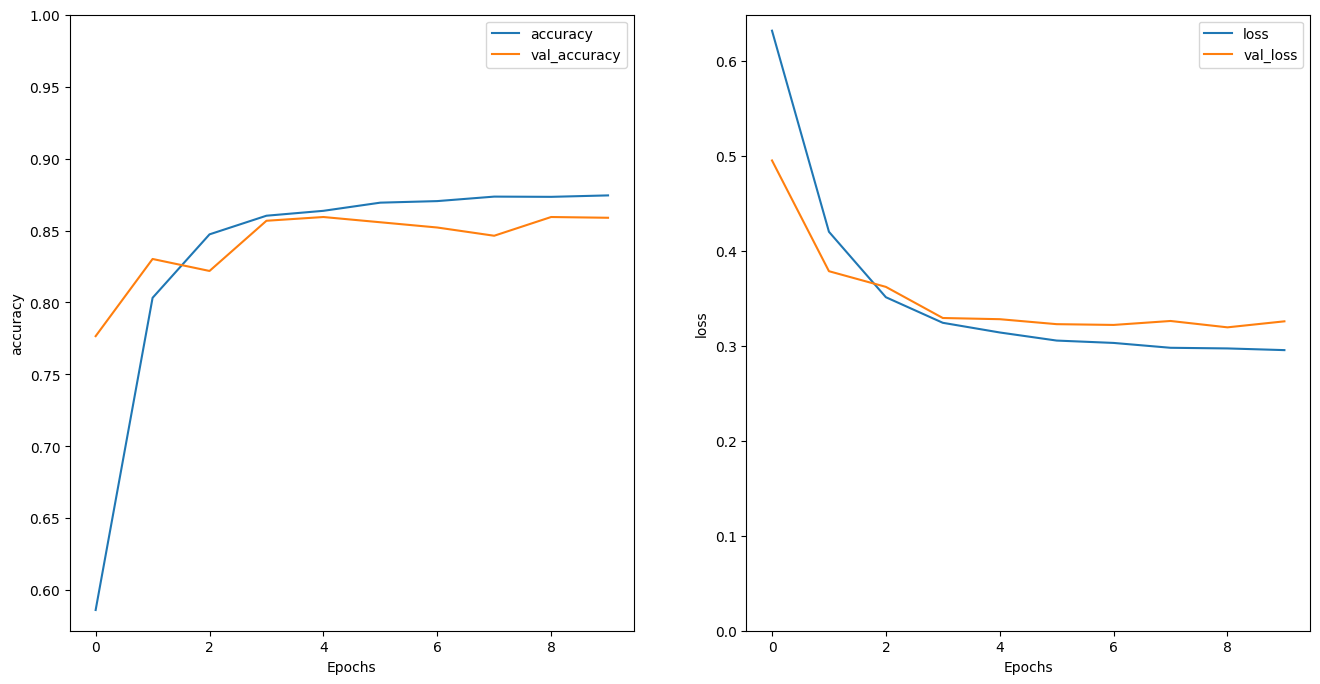

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [21]:
model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  optimizer=tf.keras.optimizers.Adam(1e-4),
  metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=2,
 validation_data=test_dataset,
 validation_steps=5)

Epoch 1/2
391/391 [==============================] - 1170s 3s/step - loss: 0.5994 - accuracy: 0.6216 - val_loss: 0.5059 - val_accuracy: 0.7781
Epoch 2/2
391/391 [==============================] - 1139s 3s/step - loss: 0.3764 - accuracy: 0.8352 - val_loss: 0.3686 - val_accuracy: 0.8219


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 252s 642ms/step - loss: 0.3356 - accuracy: 0.8432
Test Loss: 0.3356022238731384
Test Accuracy: 0.8432000279426575


In [28]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 8s 8s/step
[[-0.81503123]]


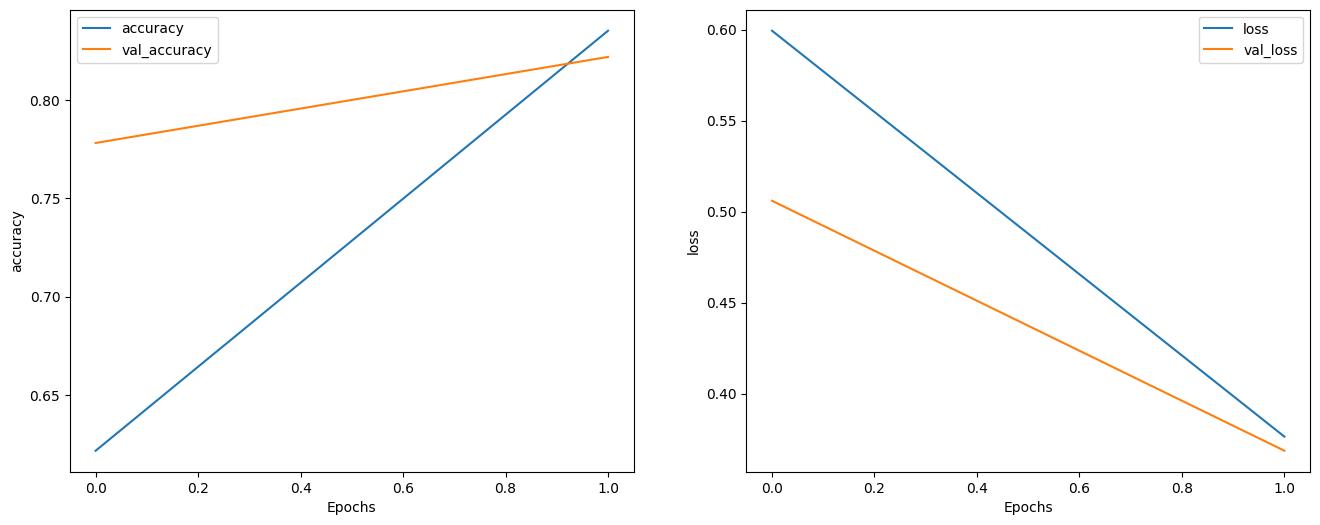

In [29]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')